# **Plant Seedling Classification**

In this notebook we will try to classify 12 plant species.

The 12 plant types are,
* Black-grass
* Charlock
* Cleavers
* Common Chickweed
* Common wheat
* Fat Hen
* Loose Silky-bent
* Maize
* Scentless Mayweed
* Shepherds Purse
* Small-flowered Cranesbill
* Sugar beet

### **The steps we will follow**



1.   Descriptive Analytics of the data
2.   Image Preprocessing
3.   Model Building
4.   Model Training
5.   Model Valitdation

**Note:** We will tune hyperparameters in the model training and validation phase

# Section 1 Loading Data 

Here we load the data and resize the data to 64x64

In [3]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import tensorflow as tf

In [4]:
scalesize = 64
#this will get all the png images from all the folder types
path_to_train = "<PATH TO THE DATA FOLDER>/train/*/*.png"

#get all the images present
files = glob(path_to_train)

#now we create 2 lists, one to contain the images
#other to contain the images
train_images_ls = []
train_label_ls = []
num=1
max_size = len(files)

#loop over the file names to read and resize images
#collect the label names as well
for img in files:
  print(str(num)+"/"+str(max_size),end="\r")
  train_images_ls.append(cv2.resize(cv2.imread(img),(scalesize,scalesize)))
  train_label_ls.append(img.split('/')[-2])
  num +=1
#converting training image list to a numpy array
train_images_ls = np.asarray(train_images_ls)

#converting the labels to pandas 
train_label_ls = pd.DataFrame(train_label_ls)

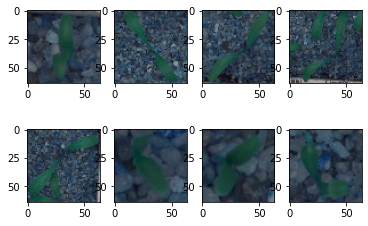

In [5]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(train_images_ls[i])

In [6]:
#summary of the training labels
train_label_ls.value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

# Image Preprocessing 

Here we will remove the background of the image and only keep the regions which belong to the plants.

In [7]:
#defining helper functions

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

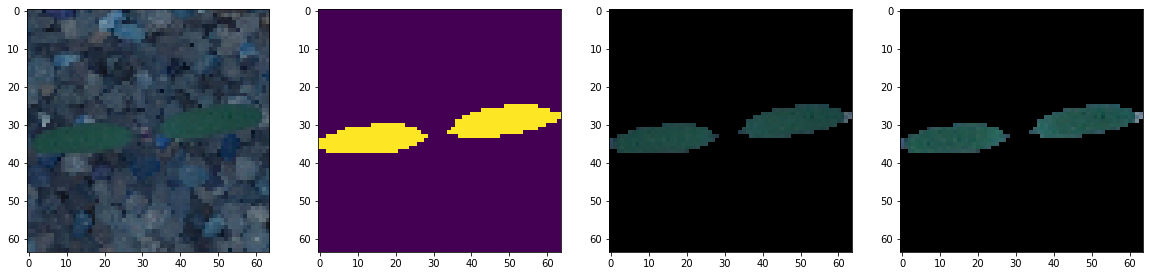

In [8]:
#Small example of the functions
# Test image to see the changes
image = train_images_ls[1876]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

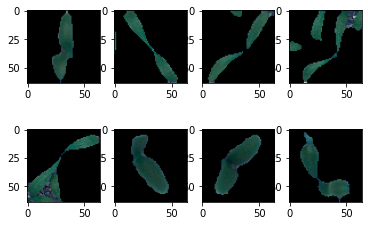

In [9]:
#now creating a new list with the corrected image
segmented_image_ls = []

for i in range(0,len(train_images_ls)):
  segmented_image_ls.append(sharpen_image(segment_plant(train_images_ls[i])))

segmented_image_ls = np.asarray(segmented_image_ls)
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(segmented_image_ls[i])

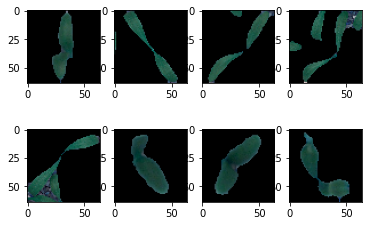

In [10]:
# Now we will normalize the images 
segmented_image_ls = segmented_image_ls/255

# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(segmented_image_ls[i])

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


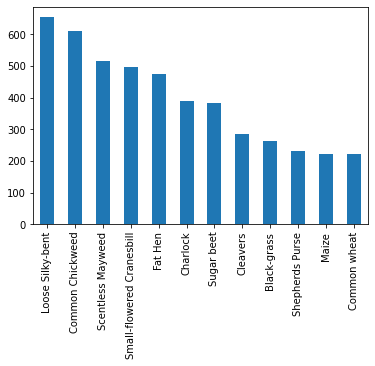

In [11]:
# Encode labels and create classes
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_label_ls[0])
print("Classes: " + str(label_encoder.classes_))
encodeTrainLabels = label_encoder.transform(train_label_ls[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
train_label_ls[0].value_counts().plot(kind='bar')

In [12]:
clearTrainLabel

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Data Augmentation

Here we will augment the data to increase the dataset size and to prevent overfitting.

In [14]:

datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
# datagen.fit(trainX)

# Model Building
Here we will build few different models and test their accuracy


In [39]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization


def create_model():
  numpy.random.seed(7)  # Fix seed

  model = Sequential()

  model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scalesize, scalesize, 3), activation='relu'))
  # model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))

  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
  # model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))

  # model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
  # # model.add(BatchNormalization(axis=3))
  # model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
  # model.add(MaxPooling2D((2, 2)))
  # # model.add(BatchNormalization(axis=3))
  # model.add(Dropout(0.1))

  model.add(Flatten())

  model.add(Dense(512, activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(512, activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(num_clases, activation='softmax'))

  model.summary()

  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
  # model.summary()

In [ ]:
create_model()

In [16]:
#check for available devices to confirm usage of GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8753870465352802940
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15021844907585187208
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


# Model K-fold Validation and Experimentation
Here we change the depth of the models and other layers and experiment to select the best mode using 5 Fold cross validation.

In [36]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
n_split=5
accuracy_ls = []
for train_index,test_index in KFold(n_split,shuffle=True,random_state=7).split(segmented_image_ls):
        x_train,x_test=segmented_image_ls[train_index],segmented_image_ls[test_index]
        y_train,y_test=clearTrainLabel[train_index],clearTrainLabel[test_index]
        datagen.fit(x_train)
        model = create_model()
        model_checkpoint = ModelCheckpoint('/content/Model/plantspecies_CNN_model.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=100), 
                    epochs=20, validation_data=(x_test, y_test),   
                    callbacks = [early_stopping, model_checkpoint])
        
        #score and accuracy of the model
        score, acc = model.evaluate(x_test,y_test)
        accuracy_ls.append(acc)
        print(accuracy_ls)
        print('Validation score:', score,'   Validation accuracy:', acc)
        tf.keras.backend.clear_session()
print()
print()
print()
print("Cross Validation Accuracy: ",sum(accuracy_ls)/5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        4864      
                                                                 
 batch_normalization_6 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 2.4123 - accuracy: 0.3300
Epoch 1: val_accuracy improved from -inf to 0.08105, saving model to /content/Model/plantspecies_CNN_model.h5
38/38 [==============================] - 8s 162ms/step - loss: 2.4123 - accuracy: 0.3300 - val_loss: 12.1749 - val_accuracy: 0.0811
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 1.6282 - accuracy: 0.4853
Epoch 2: val_accuracy did not improve from 0.08105
38/38 [==============================] - 6s 147ms/step - loss: 1.6282 - accuracy: 0.4853 - val_loss: 16.1515 - val_accuracy: 0.0547
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 1.3267 - accuracy: 0.5595
Epoch 3: val_accuracy improved from 0.08105 to 0.08632, saving model to /content/Model/plantspecies_CNN_model.h5
38/38 [==============================] - 6s 154ms/step - loss: 1.3267 - accuracy: 0.5595 - val_loss: 14.8308 - val_accuracy: 0.0863
Epoch 4/20
38/38 [==============================

# Final Model selection and Evaluation

Here we have selected the final model, we will retrain this model and see the final evaluations. 

In [38]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(segmented_image_ls, clearTrainLabel, 
                                                test_size=0.1, random_state=7, 
                                                stratify = clearTrainLabel)
datagen.fit(trainX)

In [40]:
final_model = create_model()
model_checkpoint = ModelCheckpoint('/content/Model/plantspecies_CNN_model.h5', #where to save the model
                                            save_best_only=True, 
                                            monitor='val_accuracy', 
                                            mode='max', 
                                            verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = final_model.fit_generator(datagen.flow(trainX, trainY, batch_size=100), 
            epochs=50, validation_data=(testX, testY),   
            callbacks = [early_stopping, model_checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 128)       409728    
                                                        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


43/43 [==============================] - ETA: 0s - loss: 2.2142 - accuracy: 0.2234
Epoch 1: val_accuracy improved from -inf to 0.41263, saving model to /content/Model/plantspecies_CNN_model.h5
43/43 [==============================] - 8s 157ms/step - loss: 2.2142 - accuracy: 0.2234 - val_loss: 1.7460 - val_accuracy: 0.4126
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 1.7552 - accuracy: 0.3670
Epoch 2: val_accuracy improved from 0.41263 to 0.43789, saving model to /content/Model/plantspecies_CNN_model.h5
43/43 [==============================] - 6s 149ms/step - loss: 1.7552 - accuracy: 0.3670 - val_loss: 1.5377 - val_accuracy: 0.4379
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 1.5169 - accuracy: 0.4653
Epoch 3: val_accuracy improved from 0.43789 to 0.52632, saving model to /content/Model/plantspecies_CNN_model.h5
43/43 [==============================] - 6s 148ms/step - loss: 1.5169 - accuracy: 0.4653 - val_loss: 1.3773 - val_accuracy: 0.5263


In [41]:
#Final score and accuracy of the model
score, acc = final_model.evaluate(testX,testY)
print('Validation score:', score,'   Validation accuracy:', acc)

15/15 [==============================] - 0s 9ms/step - loss: 0.3408 - accuracy: 0.8758
Validation score: 0.34077608585357666    Validation accuracy: 0.87578946352005


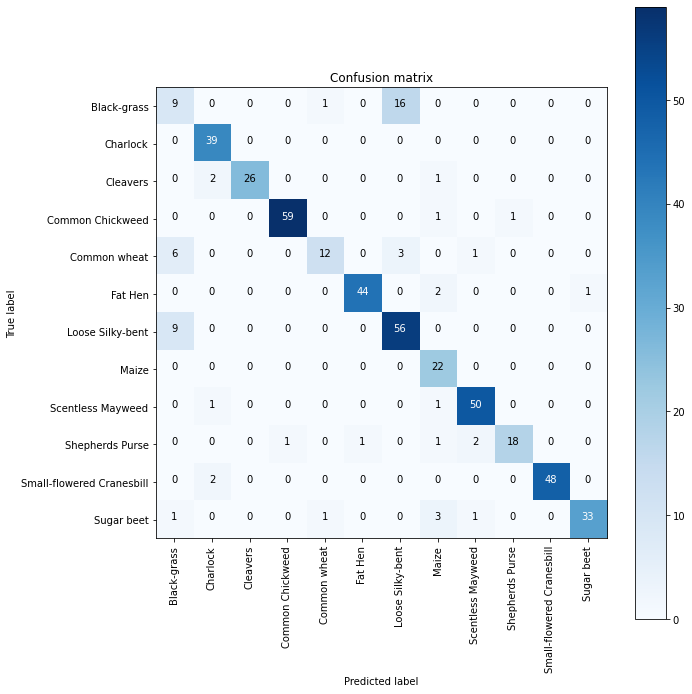

In [42]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = final_model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = label_encoder.classes_) 

# Generating the Test output
Here we will generate the submission.txt file as required by kaggle


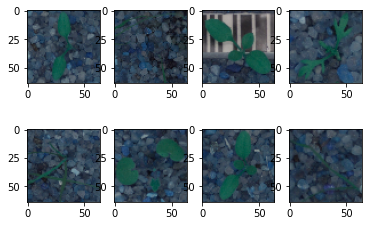

In [43]:
path = '<PATH TO THE DATA FOLDER>/test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('/')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (scalesize, scalesize)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])

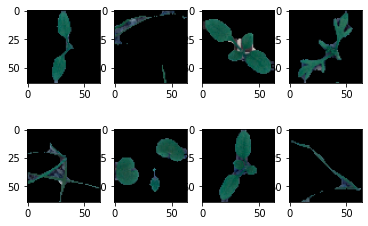

In [44]:
#now creating a new list with the corrected image
segmented_test_image_ls = []

for i in range(0,len(testImg)):
  segmented_test_image_ls.append(sharpen_image(segment_plant(testImg[i])))

segmented_test_image_ls = np.asarray(segmented_test_image_ls)
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(segmented_test_image_ls[i])

In [45]:
segmented_test_image_ls = segmented_test_image_ls / 255

In [46]:
pred = final_model.predict(segmented_test_image_ls)

In [47]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = label_encoder.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("submission.csv", index=False)

In [48]:
res.head()

,file,species
0,f9f35cbd4.png,Common Chickweed
1,65e97117e.png,Loose Silky-bent
2,3fbd0fc6a.png,Common Chickweed
3,edfdb4aeb.png,Sugar beet
4,79d93bc96.png,Loose Silky-bent
